This is a tutorial on JAX, a JIT-compiled differentiable computing library. [See here](https://jax.readthedocs.io/en/latest/) for the reference documentation.

In [2]:
# RUN THIS FIRST, prevent JAX from eating up GPU memory
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# The Basics

JAX comes with its own version of `numpy`, and `jnp` arithmetic is almost identitcal to `np` arithmeic.

In [3]:
import numpy as np
import jax.numpy as jnp

x = np.array([1., 2., 3.])
y = np.array([0., 1., 5.])
z = np.array([2., 3., 4.])
print(f"with numpy: {x * y + z}")


x_ = jnp.array([1., 2., 3.])
y_ = jnp.array([0., 1., 5.])
z_ = jnp.array([2., 3., 4.])
print(f"with jax: {x_ * y_ + z_}")

with numpy: [ 2.  5. 19.]
with jax: [ 2.  5. 19.]


Indeed, almost every conceivable `numpy` function has a `jax.numpy` counterpart:

In [4]:
np_linspace = np.linspace(0, 1, 3)
jnp_linspace = jnp.linspace(0, 1, 3)

print(f"np_linspace: {np_linspace}")
print(f"jnp_linspace: {jnp_linspace}\n")

A = np.random.normal(size = (10, 10))
np_2norm = np.linalg.norm(A, ord = 2)
jnp_2norm = jnp.linalg.norm(A, ord = 2) # notice that we can feed np array into jnp function!

print(f"np_2norm: {np_2norm:.4f}")
print(f"jnp_2norm: {jnp_2norm:.4f}\n")

np_linspace: [0.  0.5 1. ]
jnp_linspace: [0.  0.5 1. ]

np_2norm: 5.5194
jnp_2norm: 5.5194



Other packages like `matplotlib` can accept `jnp` arrays:

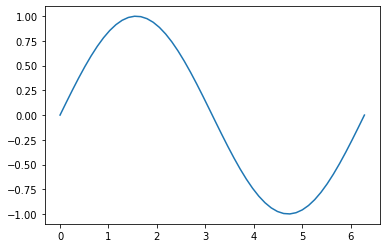

In [5]:
import matplotlib.pyplot as plt

x = jnp.linspace(0, 2 * jnp.pi)
y = jnp.sin(x)
plt.plot(x, y)

One key difference is for RNG, JAX requires the entropy to be fed in explicitly using a key, which must be split into a new key each time! [Details here](https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#jax-prng).

In [6]:
from jax import random

key = random.PRNGKey(0) # initialize key from your favorite integer

A = random.normal(key, shape = (2, 2))
print(f"A: {A}")
B = random.normal(key, shape = (2, 2)) # will get the same thing as A!
print(f"B: {B}")

key, subkey = random.split(key) # new key and subkey are different from original key
C = random.normal(key, shape = (2, 2))
print(f"C: {C}")
D = random.normal(subkey, shape = (2, 2))
print(f"D: {D}")


A: [[ 1.8160863  -0.75488514]
 [ 0.33988908 -0.53483534]]
B: [[ 1.8160863  -0.75488514]
 [ 0.33988908 -0.53483534]]
C: [[ 0.13893168  1.370668  ]
 [-0.53116107  0.02033782]]
D: [[ 1.1378784  -0.14331433]
 [-0.59153634  0.79466224]]


Another difference is in how updating arrays works; see [the documentation](https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.ndarray.at.html#jax.numpy.ndarray.at) for more details:

In [7]:
# in numpy, we can do in-place array updates:
A = np.array([1, 2, 3])
print(f"this is A: {A}")

A[0] = 0
print(f"this is the new A in numpy: {A}")


this is A: [1 2 3]
this is the new A in numpy: [0 2 3]


In [8]:
# in jax, this doesn't work:
A = jnp.array([1, 2, 3])
print(f"this is A: {A}")

A[0] = 0 # this will throw an error

this is A: [1 2 3]


TypeError: '<class 'jaxlib.xla_extension.DeviceArray'>' object does not support item assignment. JAX arrays are immutable. Instead of ``x[idx] = y``, use ``x = x.at[idx].set(y)`` or another .at[] method: https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.ndarray.at.html

In [ ]:
# instead, we have to do this:

A = A.at[0].set(0)
print(f"this is the new A: {A}")

this is the new A: [0 2 3]


# Computing Derivatives in JAX

JAX is super functional: the `grad()` function is an operator that maps a scalar-valued function to its derivative:

In [ ]:
from jax import grad

sin_grad = grad(jnp.sin)
print(f"sin'(1): {sin_grad(1.0):.4f}")
print(f"cos(1): {jnp.cos(1.0):.4f}")

sin'(1): 0.5403
cos(1): 0.5403


We can get fancy with function composition; if $f(x) = \sin(x^2) + 3x^2$, then $f'(x) = 2x\cos(x^2) + 6x$.

In [ ]:
def f(x): 
  return jnp.sin(x**2) + 3 * x**2

def grad_f_manual(x):
  return 2 * x * jnp.cos(x**2) + 6 * x

grad_f_auto = grad(f)

x = 2.0
print(f"manual f'(1): {grad_f_manual(x):.4f}")
print(f"auto f'(1): {grad_f_auto(x):.4f}")


manual f'(1): 9.3854
auto f'(1): 9.3854


We can also take gradients of multivariable functions; if 
$$f(x, y, z) = x^2 + 3\sin(y) + \cos(z),$$ 
then 
$$\nabla f(x, y, z) = (2x, 3\cos(y), -\sin(z)).$$

In [ ]:
# denote X = (x, y, z)

def f(X): 
  return X[0]**2 + 3 * jnp.sin(X[1]) + jnp.cos(X[2])

def grad_f_manual(X):
  return jnp.array([2 * X[0], 3 * jnp.cos(X[1]), -jnp.sin(X[2])])

grad_f_auto = grad(f)

X = jnp.array([2.0, 3.0, 1.0])
print(f"manual f'(1): {grad_f_manual(X)}")
print(f"auto f'(1): {grad_f_auto(X)}")

manual f'(1): [ 4.         -2.9699774  -0.84147096]
auto f'(1): [ 4.         -2.9699774  -0.84147096]


We can also differentiate with respect to other Python containers, such as dictionaries:

In [ ]:
def f(X):
  return X['x']**2 + 3 * jnp.sin(X['y']) + jnp.cos(X['z'])

def grad_f_manual(X):
  return jnp.array([2 * X['x'], 3 * jnp.cos(X['y']), -jnp.sin(X['z'])])

grad_f_auto = grad(f)

X = {'x' : 2.0, 'y' : 3.0, 'z' : 1.0}
print(f"manual f'(1): {grad_f_manual(X)}")
print(f"auto f'(1): {grad_f_auto(X)}")

manual f'(1): [ 4.         -2.9699774  -0.84147096]
auto f'(1): {'x': DeviceArray(4., dtype=float32, weak_type=True), 'y': DeviceArray(-2.9699774, dtype=float32, weak_type=True), 'z': DeviceArray(-0.84147096, dtype=float32, weak_type=True)}


Let's do a fancy example with multiple multivariate arguments; let
$$ f(x, y) = \|x\|^2 + \|y\| + \langle x, y\rangle,$$
so that
\begin{align*}
  D_xf(x, y) &= 2x + y\\
  D_yf(x, y) &= \frac{y}{\|y\|} + x
\end{align*}

In [ ]:
def f(x, y):
  return jnp.linalg.norm(x)**2 + jnp.linalg.norm(y) + jnp.inner(x, y)

Dxf = grad(f, 0) # take the derivative wrt the zeroth argument
Dyf = grad(f, 1) # take the derivative wrt the first argument

x = jnp.array([1., 2., 3.])
y = jnp.array([0, -1., 1.])

print(f"derivative wrt x: {Dxf(x, y)}")
print(f"manually computed: {2 * x + y}\n")
print(f"derivative wrt y: {Dyf(x, y)}")
print(f"manually computed: {y / jnp.linalg.norm(y) + x}")


derivative wrt x: [2. 3. 7.]
manually computed: [2. 3. 7.]

derivative wrt y: [1.        1.2928932 3.7071068]
manually computed: [1.        1.2928932 3.7071068]


The `value_and_grad()` function is useful for first-order optimization methods:

In [ ]:
from jax import value_and_grad

def f(x):
  return x ** 2

value, grad = value_and_grad(f)(3.0)
print(f"value: {value}")
print(f"grad: {grad}")

value: 9.0
grad: 6.0


# JVPs and VJPs

Define
\begin{align*}
  f(x, y) &= (x + 2y, \sin(x)e^y, y^3),\; f:\mathbb{R}^2\to\mathbb{R}^3\\
  Jf(x, y) &= \begin{bmatrix} 1 & 2 \\ \cos(x)e^y & \sin(x)e^y\\ 0 & 3y^2\end{bmatrix}\in\mathbb{R}^{3\times 2}
\end{align*}
We want to compute the Jacobian-vector product, which takes in a vector $(x, y)$ and a vector $v\in\mathbb{R}^2$, and computes $Jf(x,y)v$. JAX's `jvp()` can do this for us.

In [ ]:
from jax import jvp

def f(x):
  return jnp.array([x[0] + 2 * x[1], jnp.sin(x[0]) * jnp.exp(x[1]), x[1]**3])

def Jf_manual(x):
  return jnp.array([
    [1, 2], 
    [jnp.cos(x[0]) * jnp.exp(x[1]), jnp.sin(x[0]) * jnp.exp(x[1])],
    [0, 3 * x[1] **2]
  ])

# compute the jvp manually
def jvp_manual(x, v):
  return Jf_manual(x) @ v

x = jnp.array([1., 2.])
v = jnp.array([2., 3.])

print(f"manually computed jvp: {jvp_manual(x, v)}")

# compute the jvp using jax.jvp():

func_value, jvp_JAX = jvp(f, (x,), (v,)) # jvp returns both the function value and the jvp
print(f"JAX computed jvp: {jvp_JAX}")


manually computed jvp: [ 8.       26.637676 36.      ]
JAX computed jvp: [ 8.       26.637676 36.      ]


What if we want the full Jacobian matrix? Remember that post-multiplying a matrix with the jth standard basis vector reveals the jth column of the matrix, so can construct the full $m\times n$￼Jacobian matrix with $n$ JVPs:

In [ ]:
def Jf_JVPs(x): # compute the full Jacobian at x using JVPs
  Jf = np.zeros(shape = (3, 2))
  for j in range(2):
    # compute the jth basis vector
    ej = np.zeros(shape = 2)
    ej[j] = 1

    # set the jth column equal to JVP with v = ej
    Jf[:, j] = jvp(f, (x,), (ej,))[1] # remember jvp returns function value and jvp

  return Jf

x = jnp.array([2., 3.])

print(f"Jf with JVPs: \n {Jf_JVPs(x)}")
print(f"Jf manual: \n {Jf_manual(x)}")

Jf with JVPs: 
 [[ 1.          2.        ]
 [-8.35853291 18.26372719]
 [ 0.         27.        ]]
Jf manual: 
 [[ 1.        2.      ]
 [-8.358533 18.263727]
 [ 0.       27.      ]]


Up to some optimizations, this is basically what `jacfwd()` does:

In [ ]:
from jax import jacfwd

print(f"Jf with jacfwd(): \n {jacfwd(f)(x)}")

Jf with jacfwd(): 
 [[ 1.        2.      ]
 [-8.358533 18.263727]
 [ 0.       27.      ]]


Now let's compute the vector-Jacobian product, which takes in a vector $(x, y)$ and a vector $v\in\mathbb{R}^3$, and computes $v^TJf(x,y)$. JAX's `vjp()` can do this for us.

In [ ]:
from jax import vjp

def f(x):
  return jnp.array([x[0] + 2 * x[1], jnp.sin(x[0]) * jnp.exp(x[1]), x[1]**3])

def Jf_manual(x):
  return jnp.array([
    [1, 2], 
    [jnp.cos(x[0]) * jnp.exp(x[1]), jnp.sin(x[0]) * jnp.exp(x[1])],
    [0, 3 * x[1] **2]
  ])

# compute the vjp manually
def vjp_manual(x, v):
  return v @ Jf_manual(x)

x = jnp.array([1., 2.])
v = jnp.array([2., 3., 4.])

print(f"manually computed jvp: {vjp_manual(x, v)}")

# compute the jvp using jax.jvp():

func_value, vjp_JAX = vjp(f, x) # vjp signature is a bit different from jvp
print(f"JAX computed jvp: {vjp_JAX(v)}")


manually computed jvp: [13.976972 70.65303 ]
JAX computed jvp: (DeviceArray([13.976972, 70.65303 ], dtype=float32),)


To get the full Jacobian matrix using VJPs, recall that premultiplying a matrix by the ith standard basis vector reveals the ith row, so we can construct the full $m\times n$ Jacobian using $n$ JVPs:

In [ ]:
def Jf_VJPs(x): # compute the full Jacobian at x using VJPs
  Jf = np.zeros(shape = (3, 2))
  for i in range(3):
    # compute the ith basis vector
    ei = np.zeros(shape = 3)
    ei[i] = 1

    # set the ith column equal to JVP with v = ej
    Jf[i] = vjp(f, x)[1](ei)[0]
  return Jf

x = jnp.array([2., 3.])

print(f"Jf with VJPs: \n {Jf_VJPs(x)}")
print(f"Jf manual: \n {Jf_manual(x)}")

Jf with VJPs: 
 [[ 1.          2.        ]
 [-8.35853291 18.26372719]
 [ 0.         27.        ]]
Jf manual: 
 [[ 1.        2.      ]
 [-8.358533 18.263727]
 [ 0.       27.      ]]


Up to some optimizations, this is basically what `jacrev()` does:

In [ ]:
from jax import jacrev

print(f"Jf with jacrev(): \n {jacrev(f)(x)}")

Jf with jacrev(): 
 [[ 1.        2.      ]
 [-8.358533 18.263727]
 [ 0.       27.      ]]
